In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Add, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from collections import Counter
from scipy.interpolate import CubicSpline

# === Attention Layer ===
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = K.sum(alpha * x, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# === Augmentation Functions ===
def time_warp(X, sigma=0.2):
    orig_steps = np.arange(X.shape[1])
    X_warped = np.zeros_like(X)
    for i in range(X.shape[0]):
        random_warp = np.random.normal(loc=1.0, scale=sigma, size=(X.shape[1],))
        warped_steps = np.cumsum(random_warp)
        warped_steps = (warped_steps - warped_steps.min()) / (warped_steps.max() - warped_steps.min()) * (X.shape[1] - 1)
        cs = CubicSpline(orig_steps, X[i])
        X_warped[i] = cs(warped_steps)
    return X_warped

def add_jitter(X, sigma=0.05):
    return X + np.random.normal(loc=0.0, scale=sigma, size=X.shape)

# === Load and preprocess data ===
data = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\HAR-WISDM\Data_WISDM\WISDM_cleaned.csv")
X = data.drop('class', axis=1).values
y = data['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_reshaped = X_scaled.reshape(-1, 10, 3)
y_reshaped = y_encoded.reshape(-1)

# === Model Builder ===
def build_cnn_lstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.25)(x)

    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    x = Attention()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Cross-validation and Augmentation ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
f1_scores = []

excluded_classes = ['Walking', 'Jogging','Sitting', 'Standing']
excluded_class_ids = label_encoder.transform(excluded_classes)

for train_idx, val_idx in skf.split(X_reshaped, y_reshaped):
    print(f"\n📚 Training Fold {fold}")
    X_train, X_val = X_reshaped[train_idx], X_reshaped[val_idx]
    y_train, y_val = y_reshaped[train_idx], y_reshaped[val_idx]

    X_aug, y_aug = [], []
    counter = Counter(y_train)
    max_count = max(counter.values())

    for cls in np.unique(y_train):
        X_cls = X_train[y_train == cls]
        y_cls = y_train[y_train == cls]

        if cls in excluded_class_ids:
            print(f"⚠️ Skipping augmentation for class: {label_encoder.inverse_transform([cls])[0]}")
            X_aug.append(X_cls)
            y_aug.append(y_cls)
            continue

        n_to_add = max_count - len(X_cls)
        reps = n_to_add // len(X_cls) + 1

        X_jittered = np.concatenate([add_jitter(X_cls) for _ in range(reps)], axis=0)[:n_to_add]
        X_timewarped = np.concatenate([time_warp(X_cls) for _ in range(reps)], axis=0)[:n_to_add]
        X_augmented = np.concatenate([X_jittered, X_timewarped], axis=0)
        y_augmented = np.full(len(X_augmented), cls)

        print(f"✅ Augmented class {label_encoder.inverse_transform([cls])[0]}: original {len(X_cls)}, +aug {len(X_augmented)}")

        X_aug.append(np.concatenate([X_cls, X_augmented], axis=0))
        y_aug.append(np.concatenate([y_cls, y_augmented], axis=0))

    X_train_balanced = np.concatenate(X_aug, axis=0)
    y_train_balanced = np.concatenate(y_aug, axis=0)

    indices = np.arange(len(X_train_balanced))
    np.random.shuffle(indices)
    X_train_balanced = X_train_balanced[indices]
    y_train_balanced = y_train_balanced[indices]

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weight_dict = dict(enumerate(class_weights))

    model = build_cnn_lstm_attention_model(input_shape=(10, 3), num_classes=len(np.unique(y_reshaped)))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        X_train_balanced, y_train_balanced,
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\n🧾 Fold {fold} Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

    report = classification_report(y_val, y_pred_classes, output_dict=True)
    f1_scores.append(report['macro avg']['f1-score'])
    fold += 1

print(f"\n✅ Average Macro F1-Score across {skf.n_splits} folds: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



📚 Training Fold 1
✅ Augmented class Downstairs: original 422, +aug 2484
⚠️ Skipping augmentation for class: Jogging
⚠️ Skipping augmentation for class: Sitting
⚠️ Skipping augmentation for class: Standing
✅ Augmented class Upstairs: original 506, +aug 2316
⚠️ Skipping augmentation for class: Walking
Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.2607 - loss: 3.4035 - val_accuracy: 0.3810 - val_loss: 1.8599 - learning_rate: 0.0010
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3531 - loss: 1.6346 - val_accuracy: 0.3192 - val_loss: 1.6025 - learning_rate: 0.0010
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3595 - loss: 1.3994 - val_accuracy: 0.3367 - val_loss: 1.5625 - learning_rate: 0.0010
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3805 - loss: 1.3414 - val_accuracy: 0.4511 - val_loss: 1.4071 - learning_rate: 0.0010
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3845 - loss: 1.309

KeyboardInterrupt: 


📚 Training Fold 1
✅ Augmented class Downstairs: original 422, +aug 2484
⚠️ Skipping augmentation for class: Jogging
⚠️ Skipping augmentation for class: Sitting
⚠️ Skipping augmentation for class: Standing
✅ Augmented class Upstairs: original 506, +aug 2316
⚠️ Skipping augmentation for class: Walking
Epoch 1/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - accuracy: 0.2603 - loss: 3.4758 - val_accuracy: 0.2177 - val_loss: 2.0770 - learning_rate: 0.0010
Epoch 2/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.3588 - loss: 1.6669 - val_accuracy: 0.4899 - val_loss: 1.5237 - learning_rate: 0.0010
Epoch 3/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3595 - loss: 1.4349 - val_accuracy: 0.4096 - val_loss: 1.4728 - learning_rate: 0.0010
Epoch 4/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step - accuracy: 0.3784 - loss: 1.4054 - val_accuracy: 0.4041 - val_loss: 1.4698 - learning_rate: 0.0010
Epoch 5/100
286/286 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.3904 - loss

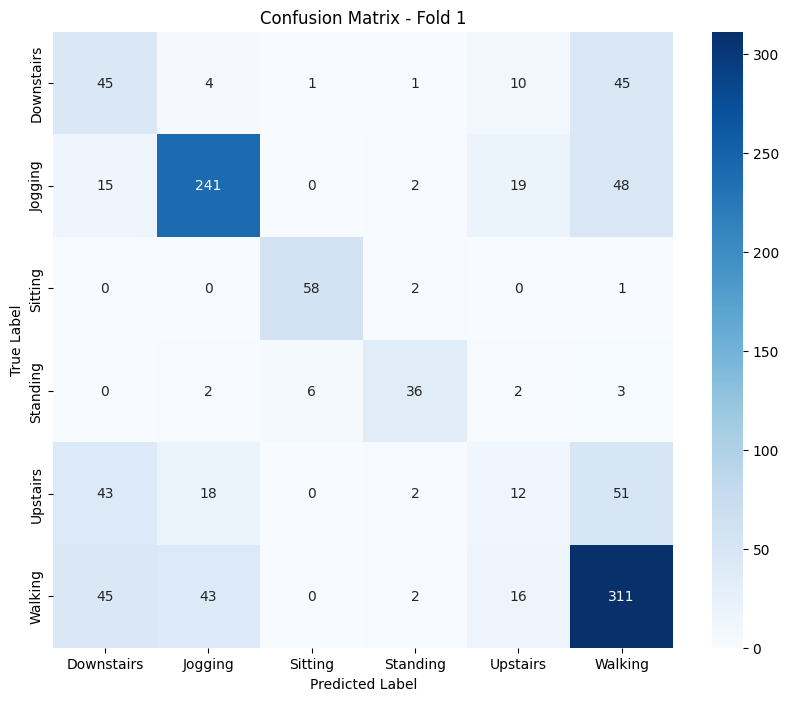

🔍 Analysis for class 'Downstairs':


TypeError: unsupported format string passed to numpy.ndarray.__format__

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Add, Layer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from collections import Counter
from scipy.interpolate import CubicSpline
import shap  # For explainability

# === Attention Layer ===
class Attention(Layer):
    def __init__(self, **kwargs):
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight", shape=(input_shape[-1], 1),
                                 initializer="glorot_uniform", trainable=True)
        self.b = self.add_weight(name="att_bias", shape=(input_shape[1], 1),
                                 initializer="zeros", trainable=True)
        super(Attention, self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x, self.W) + self.b)
        e = K.squeeze(e, axis=-1)
        alpha = K.softmax(e)
        alpha = K.expand_dims(alpha, axis=-1)
        context = K.sum(alpha * x, axis=1)
        return context

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# === Augmentation Functions ===
def time_warp(X, sigma=0.2):
    orig_steps = np.arange(X.shape[1])
    X_warped = np.zeros_like(X)
    for i in range(X.shape[0]):
        random_warp = np.random.normal(loc=1.0, scale=sigma, size=(X.shape[1],))
        warped_steps = np.cumsum(random_warp)
        warped_steps = (warped_steps - warped_steps.min()) / (warped_steps.max() - warped_steps.min()) * (X.shape[1] - 1)
        cs = CubicSpline(orig_steps, X[i])
        X_warped[i] = cs(warped_steps)
    return X_warped

def add_jitter(X, sigma=0.05):
    return X + np.random.normal(loc=0.0, scale=sigma, size=X.shape)

# === Load and preprocess data ===
data = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\HAR-WISDM\Data_WISDM\WISDM_cleaned.csv")
X = data.drop('class', axis=1).values
y = data['class'].values

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_reshaped = X_scaled.reshape(-1, 10, 3)
y_reshaped = y_encoded.reshape(-1)

# === Model Builder ===
def build_cnn_lstm_attention_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.25)(x)

    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    x = Attention()(x)
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.3)(x)

    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# === Cross-validation and Augmentation ===
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
f1_scores = []

excluded_classes = ['Walking', 'Jogging','Sitting', 'Standing']
excluded_class_ids = label_encoder.transform(excluded_classes)

for train_idx, val_idx in skf.split(X_reshaped, y_reshaped):
    print(f"\n📚 Training Fold {fold}")
    X_train, X_val = X_reshaped[train_idx], X_reshaped[val_idx]
    y_train, y_val = y_reshaped[train_idx], y_reshaped[val_idx]

    # Augmentation block
    X_aug, y_aug = [], []
    counter = Counter(y_train)
    max_count = max(counter.values())

    for cls in np.unique(y_train):
        X_cls = X_train[y_train == cls]
        y_cls = y_train[y_train == cls]

        if cls in excluded_class_ids:
            print(f"⚠️ Skipping augmentation for class: {label_encoder.inverse_transform([cls])[0]}")
            X_aug.append(X_cls)
            y_aug.append(y_cls)
            continue

        n_to_add = max_count - len(X_cls)
        reps = n_to_add // len(X_cls) + 1

        X_jittered = np.concatenate([add_jitter(X_cls) for _ in range(reps)], axis=0)[:n_to_add]
        X_timewarped = np.concatenate([time_warp(X_cls) for _ in range(reps)], axis=0)[:n_to_add]
        X_augmented = np.concatenate([X_jittered, X_timewarped], axis=0)
        y_augmented = np.full(len(X_augmented), cls)

        print(f"✅ Augmented class {label_encoder.inverse_transform([cls])[0]}: original {len(X_cls)}, +aug {len(X_augmented)}")

        X_aug.append(np.concatenate([X_cls, X_augmented], axis=0))
        y_aug.append(np.concatenate([y_cls, y_augmented], axis=0))

    X_train_balanced = np.concatenate(X_aug, axis=0)
    y_train_balanced = np.concatenate(y_aug, axis=0)

    indices = np.arange(len(X_train_balanced))
    np.random.shuffle(indices)
    X_train_balanced = X_train_balanced[indices]
    y_train_balanced = y_train_balanced[indices]

    class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
    class_weight_dict = dict(enumerate(class_weights))

    model = build_cnn_lstm_attention_model(input_shape=(10, 3), num_classes=len(np.unique(y_reshaped)))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

    history = model.fit(
        X_train_balanced, y_train_balanced,
        epochs=100,
        batch_size=32,
        class_weight=class_weight_dict,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    # Predictions
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)

    print(f"\n🧾 Fold {fold} Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"Confusion Matrix - Fold {fold}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Detailed analysis for "Downstairs" and "Upstairs"
    for cls_name in ['Downstairs', 'Upstairs']:
        if cls_name in label_encoder.classes_:
            cls_id = np.where(label_encoder.classes_ == cls_name)[0][0]
            precision, recall, f1, support = precision_recall_fscore_support(
                y_val, y_pred_classes, labels=[cls_id], average=None, zero_division=0)
            print(f"🔍 Analysis for class '{cls_name}':")
            print(f"  Precision: {precision:.3f}")
            print(f"  Recall:    {recall:.3f}")
            print(f"  F1-score:  {f1:.3f}")
            print(f"  Support:   {support}")
            print(f"  Confusion matrix row (true {cls_name}): {cm[cls_id]}")

    fold += 1

# === SHAP Explainability on last fold model ===
print("\n🔎 Running SHAP explainability on last fold model")

# Prepare a background dataset for SHAP (sample from training data)
background = X_train_balanced[np.random.choice(X_train_balanced.shape[0], 100, replace=False)]

# Create SHAP DeepExplainer (works with TF Keras)
explainer = shap.DeepExplainer(model, background)

# Take a sample of validation data for explanation
X_val_sample = X_val[:100]

# Compute SHAP values
shap_values = explainer.shap_values(X_val_sample)

# Plot SHAP summary plot for each class
for i, class_name in enumerate(label_encoder.classes_):
    print(f"\nSHAP summary for class: {class_name}")
    shap.summary_plot(shap_values[i], X_val_sample, feature_names=[f"t{t}_axis{a}" for t in range(10) for a in ['X', 'Y', 'Z']])

print("\n✅ Model training, evaluation, and explainability complete.")
